In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from transformers import AutoTokenizer
from mlxtend.plotting import plot_confusion_matrix

In [2]:
import kagglehub
import os
import shutil

# Download latest version
# for dataset see: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")

print("Path to dataset files:", path)

destination_path = "./news_detection"

os.makedirs(destination_path, exist_ok=True)

for file_name in os.listdir(path):
    shutil.move(os.path.join(path, file_name), destination_path)

fake_data = pd.read_csv(destination_path+"/News _dataset/Fake.csv")
real_data = pd.read_csv(destination_path+"/News _dataset/True.csv")

100%|██████████| 41.0M/41.0M [00:00<00:00, 151MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/emineyetm/fake-news-detection-datasets/versions/1


In [3]:
# add labels to news data
fake_data["label"]="fake"
real_data["label"]="real"

# concat real and fake news data
final_data= pd.concat([fake_data,real_data])

# reset index
final_data = final_data.sample(frac=1).reset_index(drop=True)

# drop columns with few contribution to the classification task
final_data.drop(["subject","date"], axis=1)

,title,text,label
0,WATCH: Kellyanne Conway Says Worldwide Chaos ...,Donald Trump stooge Kellyanne Conway attempted...,fake
1,Penguin Random House lands book deal with Obamas,(Reuters) - Penguin Random House has landed a ...,real
2,Spain's constitutional court suspends Catalan ...,MADRID (Reuters) - The Spanish Constitutional ...,real
3,"U.S., state courts issue conflicting rulings o...",(Reuters) - A Michigan state appeals court on ...,real
4,"Trump denies asking Comey to drop probe, decri...",WASHINGTON (Reuters) - U.S. President Donald T...,real
...,...,...,...
44893,U.S. Republicans want to slash Obama's securit...,"(This version of the May 11 story, corrects f...",real
44894,Obama to nominate Supreme Court justice when S...,"RANCHO MIRAGE, Calif. (Reuters) - President Ba...",real
44895,FOX NEWS LEGAL ANALYST: Comey’s Big Lie Expose...,Comey lied and has been caught in his lie What...,fake
44896,BROKE City of Chicago Spends Taxpayer Money St...,The Windy City is under fire for turning publi...,fake


In [4]:
# combine text and title as a whole text column
final_data["text"]=final_data["title"]+final_data["text"]

# use only text and label column in the data
final_data=final_data[["text","label"]]

# map real and fake news label as 1 and 0
final_data['label'] = final_data['label'].map({'real':1, 'fake':0})

# take a look at final data
final_data.head(10)

<ipython-input-4-62c154a05a6b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['label'] = final_data['label'].map({'real':1, 'fake':0})


,text,label
0,WATCH: Kellyanne Conway Says Worldwide Chaos ...,0
1,Penguin Random House lands book deal with Obam...,1
2,Spain's constitutional court suspends Catalan ...,1
3,"U.S., state courts issue conflicting rulings o...",1
4,"Trump denies asking Comey to drop probe, decri...",1
5,ANGRY COMMENTATOR THREATENS TRUMP: “Government...,0
6,Kidnapped Saudi released in Lebanon: Lebanese ...,1
7,The Entire Congressional Black Caucus Just St...,0
8,Five Cops Handcuff Dr. Dre At His Home Becaus...,0
9,BOMBSHELL: Classified NATO Report Praises Russ...,0


In [10]:
# define the max length of token
# Tokenization max length
max_len=100

# Sample_size, maximum 20000
sample_size=1000

# sample the data to boost training
data_0 = final_data[final_data["label"] == 0].sample(n=sample_size, random_state=42)

data_1 = final_data[final_data["label"] == 1].sample(n=sample_size, random_state=42)

balanced_data = pd.concat([data_0, data_1]).reset_index(drop=True)

data_text = balanced_data["text"]
data_label = balanced_data["label"]

# split the data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1600,), (400,), (1600,), (400,))

In [6]:
# get pre-trained model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
# tokenization function
def tokenize(X):

    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [12]:
# tokenize training and testing data
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model

# bert layer
class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert_model

    # get pooled output for classification
    def call(self, inputs):
        return self.bert(inputs)[1]

# define our own create model function
def create_model(bert_model, maxlen=100):
    # input for bert of shape (batch_size, maxlen)
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    # attention mask for bert model
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")

    # get the pooled output for bert layer
    bert_layer = BertLayer(bert_model)
    pooled_output = bert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})

    # define our own layer for classification (fine-tune)
    # randomly dropout 50% of neurons while training to avoid overfit
    x = Dropout(0.5)(pooled_output)
    # transform and activate
    x = Dense(64, activation="tanh")(x)
    # dropout again
    x = Dropout(0.5)(x)
    # transform into probability from 0-1
    output = Dense(1, activation="sigmoid")(x)

    # return our model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Create the model
model = create_model(bert_model, maxlen=100)

# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer_1 (BertLayer)  │ (None, 768)            │              0 │ attention_mask[0][0],  │
│                           │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 768)            │              0 │ bert_layer_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │         49,216 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │             65 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric you want to monitor
    patience=3,  # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)
# use ReduceLROnPlateau for changing learning rate while training for quicker converge
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduce the learning rate by a factor of 0.1
    patience=3,  # Number of epochs with no improvement to wait before reducing the learning rate
    verbose=1,
    min_lr=1e-6  # Minimum learning rate
)

In [15]:
# optimizer, learning rate and other hyperparameters
lr = 1e-04
optimizer = Adam(learning_rate=lr, epsilon=1e-08, decay=0.01,clipnorm=1.0)

# compile our model before using it
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# train and record history of training
history = model.fit(
    x={
        'input_ids': X_train_token['input_ids'],
        'attention_mask': X_train_token['attention_mask']
    },
    y=Y_train,
    epochs=20,
    batch_size=30,
    validation_data=(
        {
            'input_ids': X_test_token['input_ids'],
            'attention_mask': X_test_token['attention_mask']
        },
        Y_test
    ),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


54/54 ━━━━━━━━━━━━━━━━━━━━ 60s 736ms/step - accuracy: 0.4973 - loss: 0.8429 - val_accuracy: 0.6350 - val_loss: 0.6684 - learning_rate: 1.0000e-04
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.5122 - loss: 0.8201 - val_accuracy: 0.6300 - val_loss: 0.6633 - learning_rate: 1.0000e-04
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - accuracy: 0.5306 - loss: 0.7940 - val_accuracy: 0.6300 - val_loss: 0.6578 - learning_rate: 1.0000e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.5413 - loss: 0.7803 - val_accuracy: 0.6125 - val_loss: 0.6538 - learning_rate: 1.0000e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - accuracy: 0.5300 - loss: 0.7890 - val_accuracy: 0.6200 - val_loss: 0.6566 - learning_rate: 1.0000e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.5311 - loss: 0.7979 - val_accuracy: 0.6250 - val_loss: 0.6505 - learning_rate: 1.0000e-04
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.54

In [23]:
from tensorflow.keras.layers import Dense

# Make predictions
y_pred_proba = model.predict({
    'input_ids': X_test_token['input_ids'],
    'attention_mask': X_test_token['attention_mask']
})

# Convert probabilities to binary predictions
# Ablation study using sigmoid to predict
y_pred = Dense(units=1, activation='sigmoid')(y_pred_proba)
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step


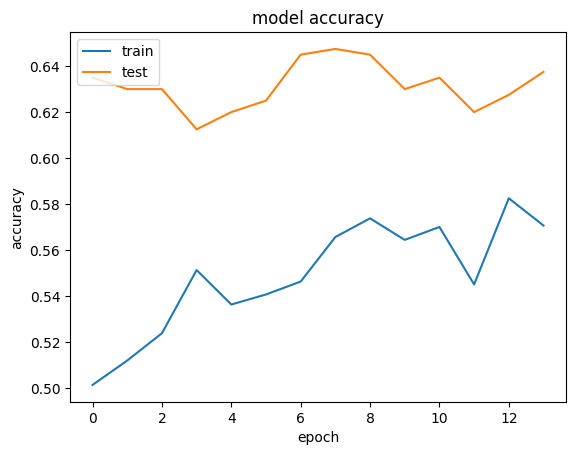

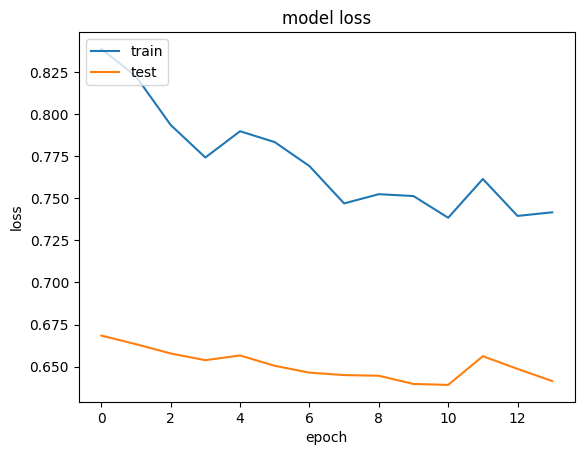

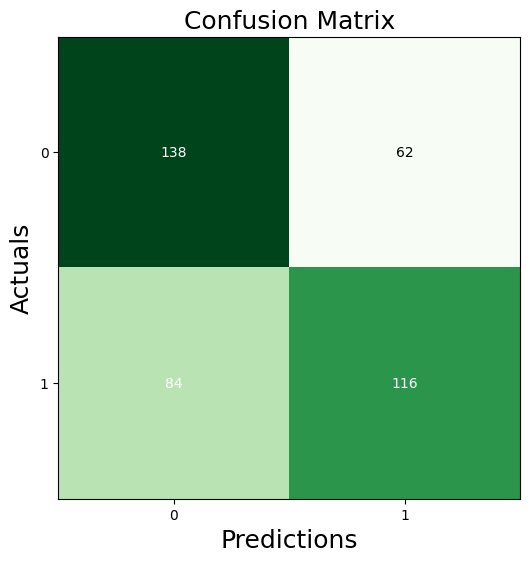

              precision    recall  f1-score   support

           0       0.62      0.69      0.65       200
           1       0.65      0.58      0.61       200

    accuracy                           0.64       400
   macro avg       0.64      0.64      0.63       400
weighted avg       0.64      0.64      0.63       400



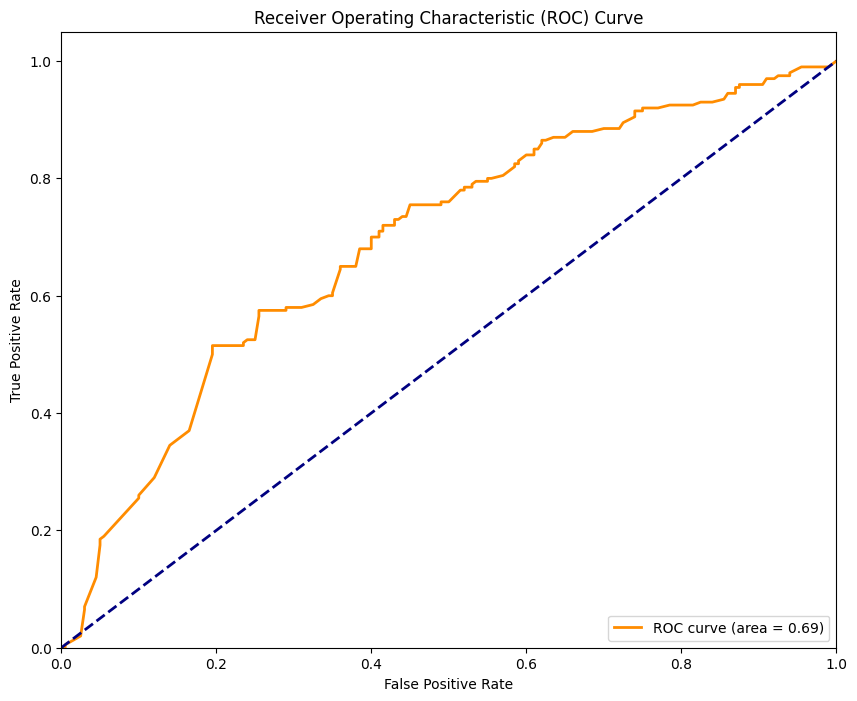

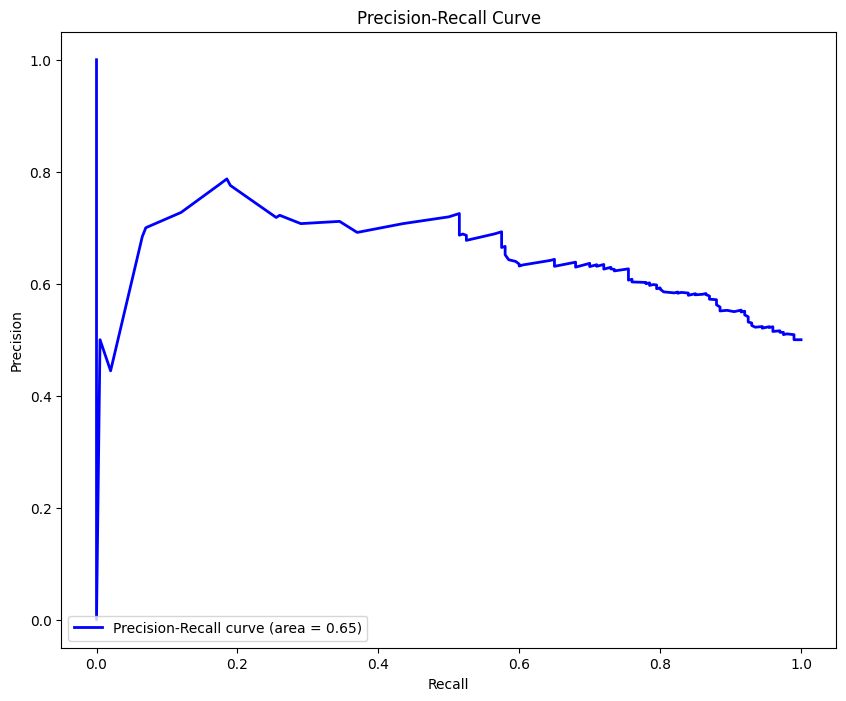

In [24]:
def plot(history,y_pred):
  # summarize history for accuracy
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  # summarize history for loss
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  conf_matrix = confusion_matrix(Y_test,y_pred)
  fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

  print(classification_report(Y_test,y_pred))


  fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)  # Removed indexing on y_pred_prob
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(10,8))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()

  precision, recall, thresholds = precision_recall_curve(Y_test, y_pred_proba)
  pr_auc = auc(recall, precision)

  plt.figure(figsize=(10,8))
  plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend(loc="lower left")
  plt.show()


plot(history.history, y_pred)